In [302]:
from abc import ABC, abstractmethod
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import List, Tuple

from tqdm import tqdm

import lib  #helper functions


In [303]:
class Temperature:
  """
  Wrapper class for a temperature value, with optional decaying
  """

  def __init__(self, value: float, decay_per_step=1, lower_bound=0):
    self.initial_value = value
    self.value = value
    self.decay_per_step = decay_per_step
    self.lower_bound = lower_bound

  def is_decaying(self):
    return self.decay_per_step != 1

  def decay(self):
    next_value = self.value * self.decay_per_step
    if next_value >= self.lower_bound:
      self.value = next_value
    else:
      self.value = self.lower_bound

In [304]:
class Agent(ABC):
  def __init__(self, env: gym.Env, temp=Temperature(1), alpha=0.1, gamma=1, num_tilings=8,
               tiles_per_tiling=10):
    self.env = env
    self.temp = temp
    self.alpha = alpha  # learning rate
    self.gamma = gamma  # discount factor
    self.num_tilings = num_tilings
    self.tiles_per_tiling = tiles_per_tiling

    self.tile_coder = lib.TileCoder(self.num_tilings,
                                    self.tiles_per_tiling,
                                    list(zip(env.observation_space.low,
                                             env.observation_space.high)))

    self.thetas = None
    self.reset()

  def z(self, state, action) -> float:
    features = self.tile_coder.encode(state)  # binary vec

    return np.sum(self.thetas[action] * features)

  def select_action(self, state) -> int:
    z_values = np.array([self.z(state, a) for a in range(self.env.action_space.n)])
    
    max_z = np.max(z_values)
    exp_values = np.exp(z_values - max_z)  # Subtract max_z to stabilize
    probabilities = exp_values / np.sum(exp_values)

    action = np.random.choice(self.env.action_space.n, p=probabilities)
    return action

  @abstractmethod
  def update(self, state, action, reward, next_state, next_action, done) -> None:
    pass

  def reset(self):
    # params setup
    self.thetas = np.random.uniform(-0.001, 0.001,
                                    (env.action_space.n, self.tile_coder.total_tiles))


Trajectory = List[Tuple['state_t', 'action_t', 'reward_t']]


class REINFORCE(Agent):
  def __init__(self, env: gym.Env, temp=Temperature(1), alpha=0.1, gamma=1, num_tilings=8,
               tiles_per_tiling=10):
    
    super().__init__(env, temp=temp, alpha=alpha, gamma=gamma, num_tilings=num_tilings,
                     tiles_per_tiling=tiles_per_tiling)
    self.v_weights = np.random.uniform(-0.001, 0.001,
                                       self.tile_coder.total_tiles)  # Baseline weights
    self.trajectory: Trajectory = list()

  def update(self, state, action, reward, next_state, next_action, done) -> None:
    if not done:
      self.trajectory.append((state, action, reward))
      return

    G = 0  # Store cumulative return
    for st, at, rt in reversed(self.trajectory):
      G = self.gamma * G + rt  # Update return
      features = self.tile_coder.encode(st)

      v_s = np.dot(self.v_weights, features)
      delta = G - v_s
      self.v_weights += self.alpha * delta * features  # Update V(s) towards G

      grad_ln_pi = features - np.sum(
        [self.thetas[a] * features for a in range(self.env.action_space.n)],
        axis=0) / self.temp.value
      self.thetas[at] += self.alpha * grad_ln_pi * delta  # Use delta = G - V(s) as advantage

    self.trajectory = []  # Clear trajectory

  def reset(self):
    super().reset()
    self.v_weights = np.random.uniform(-0.001, 0.001, self.tile_coder.total_tiles)


class ActorCritic(Agent):
  def update(self, state, action, reward, next_state, next_action, done) -> None:
    # Get current estimate and next state estimate
    current_value = self.z(state, action)
    next_value = self.z(next_state, next_action) if not done else 0

    td_err = reward + self.gamma * next_value - current_value

    # Update critic
    features = self.tile_coder.encode(state)
    self.thetas[action] += self.alpha * td_err * features

    # Update actor
    # with softmax policy, derive the gradient with respect to theta
    policy_val = np.sum([np.exp(self.z(state, a)) * self.thetas[a] * features for a in
                         range(self.env.action_space.n)], axis=0) / np.sum(
      [np.exp(self.z(state, a)) for a in range(self.env.action_space.n)])
    grad_ln_pi = features - policy_val
    self.thetas[action] += self.alpha * grad_ln_pi * td_err


In [305]:
def run_experiment(agent, num_runs: int, num_episodes: int):
  performances_across_runs = np.zeros(num_episodes)

  with tqdm(total=num_runs * num_episodes) as pbar:
    for run in range(num_runs):
      agent.reset()
      for episode in range(num_episodes):
        # initialize env 
        reward_throughout_ep = 0
        state, info = agent.env.reset()
        is_terminal = False
        truncated = False

        while not is_terminal and not truncated:
          action = agent.select_action(state)

          next_state, reward, is_terminal, truncated, info = agent.env.step(action)
          next_state = np.double(next_state)

          reward_throughout_ep += reward

          next_action = agent.select_action(next_state)

          agent.update(state,
                       action,
                       reward,
                       next_state,
                       next_action,
                       is_terminal or truncated)

          state, action = next_state, next_action
          
        agent.temp.decay()
        performances_across_runs[episode] += reward_throughout_ep

        pbar.update(1)

  return performances_across_runs / num_runs

In [306]:
NUM_RUNS = 50
NUM_EPISODES = 1000

100%|██████████| 50000/50000 [04:32<00:00, 183.47it/s]


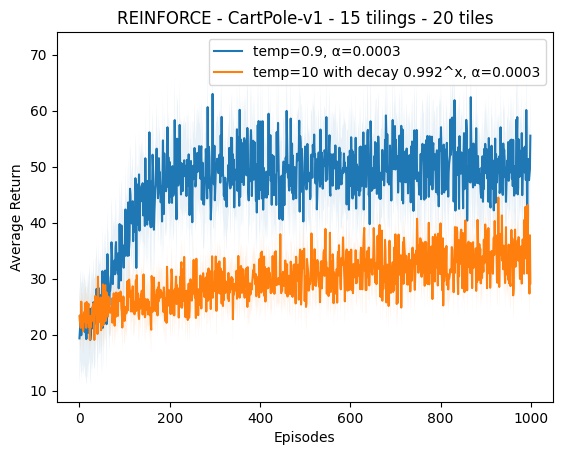

In [307]:
env_name = 'CartPole-v1'
env = gym.make(env_name)
agent = REINFORCE
temps = [Temperature(0.9), Temperature(10, decay_per_step=0.992, lower_bound=0.1)]

gamma = 0.85
alpha = 0.0003
tilings = {
  'num_tilings': 15,
  'num_tiles': 20
}

for temp in temps:
  exp_agent = agent(env,
                    temp=temp,
                    alpha=alpha,
                    gamma=gamma,
                    num_tilings=tilings['num_tilings'],
                    tiles_per_tiling=tilings['num_tiles'])

  results = run_experiment(exp_agent, NUM_RUNS, NUM_EPISODES)

  if exp_agent.temp.decay_per_step == 1:
    label = f'temp={exp_agent.temp.value}, α={exp_agent.alpha} '
  else:
    label = f'temp={exp_agent.temp.initial_value} with decay {exp_agent.temp.decay_per_step}^x, α={exp_agent.alpha}'

  plt.plot(results, label=label)

  std_results = np.std(results, axis=0)
  plt.fill_between(range(NUM_EPISODES), results - std_results, results + std_results,
                   alpha=0.1)

plt.title(
  f'{agent.__name__} - {env_name} - {tilings["num_tilings"]} tilings - {tilings["num_tiles"]} tiles'
)

plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.legend()
plt.show()

100%|██████████| 50000/50000 [05:35<00:00, 148.98it/s]


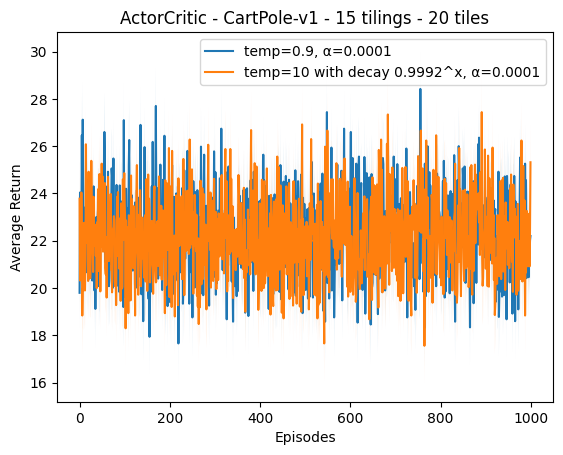

In [308]:
env_name = 'CartPole-v1'
env = gym.make(env_name)
agent = ActorCritic
temps = [Temperature(0.9), Temperature(10, decay_per_step=0.9992, lower_bound=0.1)]

alpha = 0.0001
gamma = 0.85
tilings = {
  'num_tilings': 15,
  'num_tiles': 20
}


for temp in temps:

  exp_agent = agent(env,
                    temp=temp,
                    alpha=alpha,
                    gamma=gamma,
                    num_tilings=tilings['num_tilings'],
                    tiles_per_tiling=tilings['num_tiles'])

  results = run_experiment(exp_agent, NUM_RUNS, NUM_EPISODES)

  if exp_agent.temp.decay_per_step == 1:
    label = f'temp={exp_agent.temp.initial_value}, α={exp_agent.alpha} '
  else:
    label = f'temp={exp_agent.temp.initial_value} with decay {exp_agent.temp.decay_per_step}^x, α={exp_agent.alpha}'

  plt.plot(results, label=label)

  std_results = np.std(results, axis=0)
  plt.fill_between(range(NUM_EPISODES), results - std_results, results + std_results,
                   alpha=0.1)

plt.title(
  f'{agent.__name__} - {env_name} - {tilings["num_tilings"]} tilings - {tilings["num_tiles"]} tiles'
)

plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.legend()
plt.show()

100%|██████████| 50000/50000 [29:27<00:00, 28.29it/s]


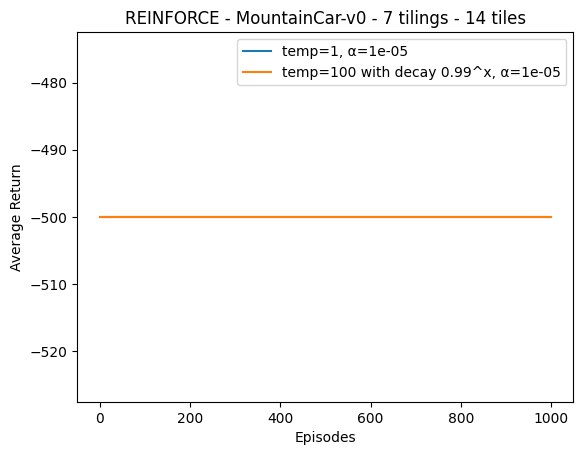

In [312]:
env_name = "MountainCar-v0"
env = gym.make(env_name, max_episode_steps=500)
temps = [Temperature(1), Temperature(100, decay_per_step=0.99, lower_bound=0.1)]
agent = REINFORCE

alpha = 0.00001
gamma = 1
tilings = {
  'num_tilings': 7,
  'num_tiles': 14
}

for temp in temps:

  exp_agent = agent(env,
                    temp=temp,
                    alpha=alpha,
                    gamma=gamma,
                    num_tilings=tilings['num_tilings'],
                    tiles_per_tiling=tilings['num_tiles'])

  results = run_experiment(exp_agent, NUM_RUNS, NUM_EPISODES)

  if exp_agent.temp.decay_per_step == 1:
    label = f'temp={exp_agent.temp.initial_value}, α={exp_agent.alpha} '
  else:
    label = f'temp={exp_agent.temp.initial_value} with decay {exp_agent.temp.decay_per_step}^x, α={exp_agent.alpha}'

  plt.plot(results, label=label)

  std_results = np.std(results, axis=0)
  plt.fill_between(range(NUM_EPISODES), results - std_results, results + std_results,
                   alpha=0.1)

plt.title(
  f'{agent.__name__} - {env_name} - {tilings["num_tilings"]} tilings - {tilings["num_tiles"]} tiles'
)

plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.legend()
plt.show()


100%|██████████| 50000/50000 [15:49<00:00, 52.66it/s]


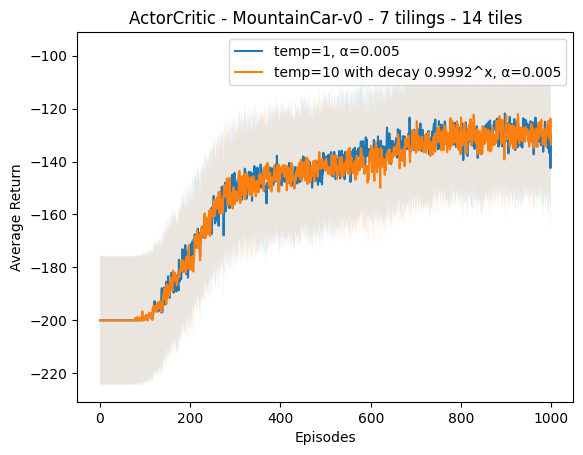

In [311]:
agent = ActorCritic
env_name = "MountainCar-v0"
env = gym.make(env_name, max_episode_steps=200)
temps = [Temperature(1), Temperature(10, decay_per_step=0.9992, lower_bound=0.01)]

alpha = 0.005
gamma = 1
tilings = {
  'num_tilings': 7,
  'num_tiles': 14
}

for temp in temps:

  exp_agent = agent(env,
                    temp=temp,
                    alpha=alpha,
                    gamma=gamma,
                    num_tilings=tilings['num_tilings'],
                    tiles_per_tiling=tilings['num_tiles'])

  results = run_experiment(exp_agent, NUM_RUNS, NUM_EPISODES)

  if exp_agent.temp.decay_per_step == 1:
    label = f'temp={exp_agent.temp.initial_value}, α={exp_agent.alpha} '
  else:
    label = f'temp={exp_agent.temp.initial_value} with decay {exp_agent.temp.decay_per_step}^x, α={exp_agent.alpha}'

  plt.plot(results, label=label)

  std_results = np.std(results, axis=0)
  plt.fill_between(range(NUM_EPISODES), results - std_results, results + std_results,
                   alpha=0.1)

plt.title(
  f'{agent.__name__} - {env_name} - {tilings["num_tilings"]} tilings - {tilings["num_tiles"]} tiles'
)

plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.legend()
plt.show()
